# Image analysis with Gammapy (run pipeline)

In this tutorial we'll learn how to make 2-dimensional images with Gammapy:
counts, background, excess, significance, exposure and flux.

We will use a "pipeline" or "workflow" class, the `StackedObsImageMaker`, that takes the inputs and some parameters as input, and then computes all images when we call the `make_images` method, i.e. without us having to write a lot code or know how it's implemented.

There's another tutorial ([image_analysis.ipynb](image_analysis.ipynb)) that executes the analysis using lower-level classes and methods in Gammapy. That other notebook would be useful to you if you'd like to understand what method is executed, or if you'd like to tweak it for your use case.

In this tutorial we will use the folling Gammapy classes:

- [gammapy.data.DataStore](http://docs.gammapy.org/en/latest/api/gammapy.data.DataStore.html) to load the data to stack in the images
- [gammapy.image.SkyImage](http://docs.gammapy.org/en/latest/api/gammapy.image.SkyImage.html) to create the reference image in which we want to stack the data
- [gammapy.image.SkyMask](http://docs.gammapy.org/en/latest/api/gammapy.image.SkyMask.html) for computing the BKG model 
- [gammapy.scripts.StackedObsImageMaker](http://docs.gammapy.org/en/latest/api/gammapy.scripts.StackedObsImageMaker.html) to create the images

We use 4 Crab observations from H.E.S.S. for testing.

## Setup

As usual, we'll start with some setup for the notebook, and import the functionality we need.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.table import Table

from gammapy.data import DataStore
from gammapy.image import SkyImage, SkyMask
from gammapy.scripts import StackedObsImageMaker
from gammapy.utils.energy import Energy

## Define inputs

We start by defining the inputs to use for the analysis:

* which data and instrument response functions to use
* sky image geometry
* energy band
* maximum field of view offset cut

The data (events, background models, effective area for exposure computation) consist of a few H.E.S.S. Crab observation runs as example. The background models there were produced as explained in the [background_model.ipynb](background_model.ipynb) tutorial.

In [3]:
# What data to analyse
data_store = DataStore.from_dir('$GAMMAPY_EXTRA/test_datasets/cube/data')
# Define runlist
obs_table = Table()
obs_table['OBS_ID'] = [23523, 23526, 23592]
# There's a problem with the PSF for run 23559, so we don't use that run for now.

In [4]:
# Define sky image
ref_image = SkyImage.empty(
    nxpix=300, nypix=300, binsz=0.02,
    xref=83.63, yref=22.01,
    proj='TAN', coordsys='CEL',
)

In [5]:
# Define energy band
energy_band = Energy([1, 10], 'TeV')

In [6]:
# Define maximum field of view offset cut
offset_band = Angle([0, 2.49], 'deg')

You define an exclusion mask that will be use to create the backgroud 2D map. The background map are normalized on the counts map outside the exclusion region

In [7]:
# Define exclusion mask (known gamma-ray sources)
# This is used in the background model image estimation
exclusion_mask = SkyMask.read('$GAMMAPY_EXTRA/datasets/exclusion_masks/tevcat_exclusion.fits')
exclusion_mask = exclusion_mask.reproject(reference=ref_image)

# If you don't have an exclusion mask,
# you could also start with an empty one
# exclusion_mask = SkyMask.empty_like(ref_image)

## Make the images

To make the images, we just pass the inputs to `StackedObsImageMaker` and then call the `make_images` method. Creating the `StackedObsImageMaker` doesn't do any computations, it just stores the parts as data members, all the computation happens in the `make_images` method.

In [8]:
image_maker = StackedObsImageMaker(
    empty_image=ref_image,
    energy_band=energy_band,
    offset_band=offset_band,
    data_store=data_store,
    obs_table=obs_table,
    exclusion_mask=exclusion_mask,
)

In [9]:
image_maker.make_images(
    make_background_image=True,
    for_integral_flux=True,
    radius=4,
)

/Users/deil/Library/Python/3.5/lib/python/site-packages/gammapy/stats/poisson.py:254: RuntimeWarning: divide by zero encountered in true_divide
  term_b = sqrt(n_on * log(n_on / mu_bkg) - n_on + mu_bkg)


## Check the results

The resulting sky images are stored in the `image_maker.images` property.

Let's have a look ...

### Counts image

(<matplotlib.figure.Figure at 0x10840d518>,
 <matplotlib.colorbar.Colorbar at 0x10d639550>)

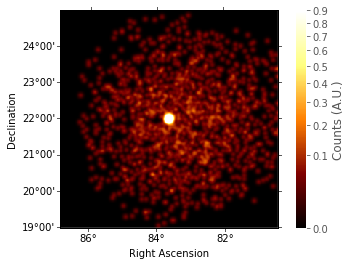

In [10]:
counts_image = image_maker.images['counts']
norm = counts_image.plot_norm(stretch='sqrt', min_cut=0, max_cut=0.9)
counts_image.smooth(radius=0.08 * u.deg).plot(norm=norm, add_cbar=True)

### Background Image

(<matplotlib.figure.Figure at 0x112f4d9b0>,
 <matplotlib.colorbar.Colorbar at 0x112f679e8>)

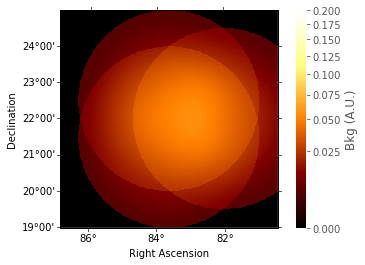

In [11]:
background_image = image_maker.images['bkg']
norm = counts_image.plot_norm(stretch='sqrt', min_cut=0, max_cut=0.2)
background_image.plot(norm=norm, add_cbar=True)

### Excess Image

(<matplotlib.figure.Figure at 0x10cc41c50>,
 <matplotlib.colorbar.Colorbar at 0x10d42d908>)

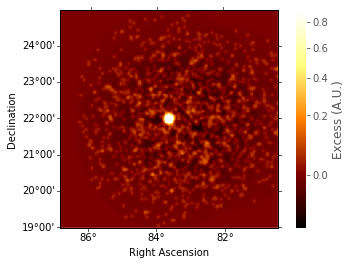

In [12]:
excess_image = image_maker.images['excess']
norm = excess_image.plot_norm(stretch='sqrt', min_cut=0, max_cut=0.9)
excess_image.smooth(radius=0.08 * u.deg).plot(norm=norm,add_cbar=True)

### Significance Image

(<matplotlib.figure.Figure at 0x10d1f0e80>,
 <matplotlib.colorbar.Colorbar at 0x10d8b8cf8>)

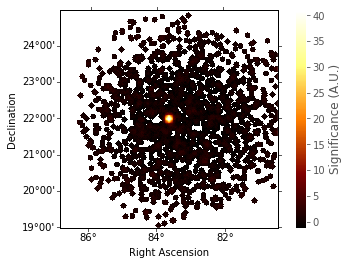

In [13]:
# Looks like a leopard, because pixels with `NaN`
# values are shown in white, 
image_maker.images["significance"].plot(add_cbar=True)

### Exposure Image

(<matplotlib.figure.Figure at 0x10d8d2fd0>,
 <matplotlib.colorbar.Colorbar at 0x10ee26630>)

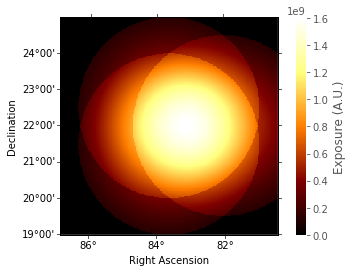

In [14]:
image_maker.images["exposure"].plot(add_cbar=True)

## Exercises

* For the output image, create a cutout zooming in on the Crab nebula, and add a marker at the Crab pulsar position
* Change the energy band to something else you like and re-run the whole analysis
* Change the sky image to Galactic coordinates and re-run the analysis
* Change the maximum FOV offset cut to something smaller (e.g. 1.5 deg) and re-run the analysis